In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x,c=0,w=1):
    return 1.0/(1.0+np.exp(-(x-c)/w))

def d1_sigmoid(x,c=0,w=1):
    return (1.0/w)*sigmoid(x,c,w)*(1.0-sigmoid(x,c,w))

class Change1(gym.Env):
    """Model Change environment
    This game presents moves along a linear chain of states, 
    where each action is the number of states to take (from 1 to 10),
    which moves along the chain.  The state will be returned as both the 
    current integer-index, and the value of a scaler from 0 to 1.  This
    scaler will vary according to a sigmoid function, defined at the time of 
    enviornment instantiation (define width and center position).
    
    The reward from each point will be the derivative of this sigmoid function,
    offset and rescaled by certain criteria passed to the env at creation.
    
    The goal is thus to take large jumps along the path when nothing is changing,
    and small steps when changing dramatically.  The game completes when a move 
    takes the state beyond end endpoint.

    The observed state is the current state in the chain (0 to n-1) and value of scaler.
    """    
    def __init__(self, L=500, c=300, w = 10, sinkscore = 0.2, power=.50, lookback=4):
        self.L = L
        self.c = c  # center of sigmoid
        self.w = w  # width of sigmoid
        self.power = power
        self.sinkscore = sinkscore #fraction to drop score floor
        self.lookback = lookback #how many previous entries to remember
        
        self.action_space = spaces.Discrete(10) #assume we can take steps 1 to 10

        #setup observation_space
        high = np.array((self.lookback+1)*[
            int(self.L),
            np.finfo(np.float32).max])
        low = np.array((self.lookback+1)*[
            int(0),
            -1.0*np.finfo(np.float32).max])
            
        self.observation_space = spaces.Box(low, high, dtype=np.float32)
        ##############

        self.seed()
        
        

        #setup value-map
        #self.x = np.arange(0,self.L,dtype=int)
        #self.value_map = sigmoid(self.x,c=self.c,w=self.w)
        #setup score-map
        #self.score_map =d1_sigmoid(self.x,c=self.c,w=self.w)**self.power-self.sinkscore*max(d1_sigmoid(self.x,c=self.c,w=self.w)**self.power) 

        #state needs to begin with a bunch of nothing
        self.state = np.array((self.lookback+1)*[0.0, 0.0])
        self.state[0] = 0
        #self.state[1] = self.value_map[0] #first value
        self.state[1] = self.value_map_func(0) #first value

        #####################
        #fill out first N=lookback spaces by taking single-steps
        for _ in range(self.lookback):
            self.step(0)

    def value_map_func(self,x):
        return sigmoid(x,c=self.c, w=self.w)

    def score_map_func(self,x):
        return d1_sigmoid(x,c=self.c,w=self.w)**self.power-self.sinkscore

    def report(self):
        print ("at site "+str((int(self.state[0]))) +" with value "+str(self.state[1]))
        print ("back\tvalue")
        for i in np.arange(2,2*self.lookback+1,2):
            print (str(int(self.state[i]))+'\t'+str(self.state[i+1]))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self,action):
        assert self.action_space.contains(action)
        newstate = np.roll(self.state,2)
        newstate[2] = 0
        newstate[0] = 0
        
        for i in np.arange(2,int(self.lookback*2+1),2):
            newstate[i] = newstate[i]+(action+1)
            
        newstate[0] = int(self.state[0])+(action+1)
        
        
        if newstate[0] >= self.L:
            done = True
            newstate[0] = self.L-1
        else:
            done = False
            
        newstate[1] = self.value_map_func(newstate[0])
        self.state = newstate
        
        reward = self.score_map_func(self.state[0])
        
        return self.state, reward, done, {}

    def reset(self, cmin= 10, cmax = 490, wmin = 1, wmax = 10, power = .5):
        return self.random_reset(cmin=cmin,cmax=cmax,wmin=wmin,wmax=wmax, power=power)

    def random_reset(self,cmin = 10, cmax=490, wmin = 1, wmax = 10, power=.5):
        self.c = np.random.random()*(cmax-cmin)+cmin
        self.w = np.random.random()*(wmax-wmin)+wmin
        
        self.power = power
        
        #self.x = np.arange(0,self.L,dtype=int)
        #self.score_map =d1_sigmoid(self.x,c=self.c,w=self.w)**self.power-self.sinkscore*max(d1_sigmoid(self.x,c=self.c,w=self.w)**self.power) 
        #self.value_map = sigmoid(self.x,c=self.c,w=self.w)
        
        #state needs to begin with a bunch of nothing
        self.state = np.array((self.lookback+1)*[0.0, 0.0])
        self.state[0] = 0
        self.state[1] = self.value_map_func(self.state[0]) #first value
        
        #fill out first N=lookback spaces by taking single-steps
        for _ in range(self.lookback):
            self.step(0)
        
        return self.state

In [3]:
env = Change1(c=100, L=300, lookback=int(10),power=.25)

In [5]:
env.report()

at site 10 with value 0.00012339457598623172
back	value
1	0.00011165334062956276
2	0.00010102919390777289
3	9.141587385216144e-05
4	8.271722285166639e-05
5	7.484622751061123e-05
6	6.772414961977023e-05
7	6.127973961660248e-05
8	5.5448524722794907e-05
9	5.0172164683764205e-05
10	4.5397868702434395e-05


In [79]:
def random_flips(num_flips = 3, L = 100,amp_max=1,wmax=8,wmin=2,power = .5,sinkscore = .25):
    cen_list = np.random.random(3)*L
    amp_list = (np.random.random(3)-.5)*2*amp_max
    wid_list = np.random.random(3)*(wmax-wmin)+wmin
    
    x = np.linspace(0,L,1001)
    
    my_score = np.zeros(len(x)) - sinkscore
    
    my_func = np.zeros(len(x)) 
    
    for i in range(num_flips):
        my_func += sigmoid(x,cen_list[i],wid_list[i])*amp_list[i]
        my_score += d1_sigmoid(x,cen_list[i],w=wid_list[i])**power
    
    
    
    
    plt.figure()
    plt.plot(x,my_func)
    plt.plot(x,my_score)
    #return my_func

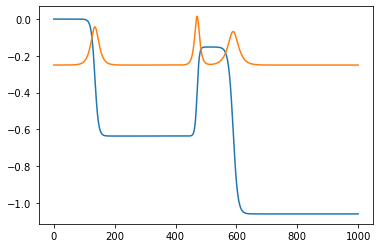

In [115]:
random_flips(L=1000)

In [95]:
np.random.random(3)*(1--1)+-1

array([-0.45521735])

In [328]:
class Change2(gym.Env):
    """Model Change environment
    This game presents moves along a linear chain of states, 
    where each action is the number of states to take (from 1 to 10),
    which moves along the chain.  The state will be returned as both the 
    current integer-index, and the value of a scaler from 0 to 1.  This
    scaler will vary according to a sigmoid function, defined at the time of 
    enviornment instantiation (define width and center position).
    
    The reward from each point will be the derivative of this sigmoid function,
    offset and rescaled by certain criteria passed to the env at creation.
    
    The goal is thus to take large jumps along the path when nothing is changing,
    and small steps when changing dramatically.  The game completes when a move 
    takes the state beyond end endpoint.

    The observed state is the current state in the chain (0 to n-1) and value of scaler.
    """    
    def __init__(self, L=500, wmin=1, wmax=10, cmin=100, cmax=400, amin=-1,amax=1,
                    sinkscore = 0.2, power=.50, lookback=4, num_flips = 3):
        
        self.num_flips = num_flips
        self.L = L

        self.clist = np.random.random(self.num_flips)*(cmax-cmin)+cmin
        self.wlist = np.random.random(self.num_flips)*(wmax-wmin)+wmin
        self.alist = np.random.random(self.num_flips)*(amax-amin)+amin
        
        self.power = power
        self.sinkscore = sinkscore #fraction to drop score floor
        self.lookback = lookback #how many previous entries to remember
        
        self.action_space = spaces.Discrete(10) #assume we can take steps 1 to 10

        #setup observation_space
        high = np.array((self.lookback+1)*[
            int(self.L),
            np.finfo(np.float32).max])
        low = np.array((self.lookback+1)*[
            int(0),
            -1.0*np.finfo(np.float32).max])
            
        self.observation_space = spaces.Box(low, high, dtype=np.float32)
        ##############

        self.seed()
        
        
        #state needs to begin with a bunch of nothing
        self.state = np.array((self.lookback+1)*[0.0, 0.0])
        self.state[0] = 0
        self.state[1] = self.value_map_func(0) #first value

        #####################
        #fill out first N=lookback spaces by taking single-steps
        for _ in range(self.lookback):
            self.step(0)

    def value_map_func(self,x):
        my_func = 0*x
            
        for i in range(self.num_flips):
            my_func += sigmoid(x,self.clist[i],self.wlist[i])*self.alist[i]
        return my_func
            
    def score_map_func(self,x):
        my_score = 0*x - self.sinkscore
        for i in range(self.num_flips):
            my_score += d1_sigmoid(x,self.clist[i],self.wlist[i])**self.power
        return my_score
    

    def report(self):
        print ("at site "+str((int(self.state[0]))) +" with value "+str(self.state[1]))
        print ("back\tvalue")
        for i in np.arange(2,2*self.lookback+1,2):
            print (str(int(self.state[i]))+'\t'+str(self.state[i+1]))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self,action):
        assert self.action_space.contains(action)
        newstate = np.roll(self.state,2)
        newstate[2] = 0
        newstate[0] = 0
        
        for i in np.arange(2,int(self.lookback*2+1),2):
            newstate[i] = newstate[i]+(action+1)
            
        newstate[0] = int(self.state[0])+(action+1)
        
        
        if newstate[0] >= self.L:
            done = True
            newstate[0] = self.L-1
        else:
            done = False
            
        newstate[1] = self.value_map_func(newstate[0])
        self.state = newstate
        
        reward = self.score_map_func(self.state[0])
        
        return self.state, reward, done, {}
    
    def reset(self, wmin=1, wmax=10, cmin=100, cmax=400, amin=-1,amax=1,
                    sinkscore = 0.2, power=.50, num_flips = 3):
        
        self.num_flips = num_flips

        self.clist = np.random.random(self.num_flips)*(cmax-cmin)+cmin
        self.wlist = np.random.random(self.num_flips)*(wmax-wmin)+wmin
        self.alist = np.random.random(self.num_flips)*(amax-amin)+amin
        
        self.power = power
        self.sinkscore = sinkscore #fraction to drop score floor
        
        self.power = power
        
        
        #state needs to begin with a bunch of nothing
        self.state = np.array((self.lookback+1)*[0.0, 0.0])
        self.state[0] = 0
        self.state[1] = self.value_map_func(self.state[0]) #first value
        
        #fill out first N=lookback spaces by taking single-steps
        for _ in range(self.lookback):
            self.step(0)
        
        return self.state

In [329]:
env = Change2(sinkscore=.02, amin=-1, amax=1, num_flips=1)

In [348]:
env.reset(num_flips=0)

array([4., 0., 1., 0., 2., 0., 3., 0., 4., 0.])

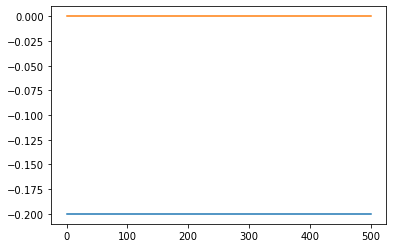

In [349]:
plt.figure()
x = np.linspace(0,500,1001)
plt.plot(x,env.score_map_func(x))
plt.plot(x,env.value_map_func(x))

In [273]:
x

array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
       0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
       1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
       1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
       2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
       2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
       3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
       3.57142857, 3.67346939, 3.7755102 , 3.87755102, 3.97959184,
       4.08163265, 4.18367347, 4.28571429, 4.3877551 , 4.48979592,
       4.59183673, 4.69387755, 4.79591837, 4.89795918, 5.        ])

In [350]:
env.report()

at site 4 with value 0.0
back	value
1	0.0
2	0.0
3	0.0
4	0.0
